### Unspliced spliced ratio

In [ ]:
import time
import timeit
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from tqdm import tqdm
from scipy.stats import mannwhitneyu

# transparent background
plt.rcParams.update({
    "figure.facecolor":  (0.0, 0.0, 0.0, 0.0),  
    "axes.facecolor":    (0.0, 0.0, 0.0, 0.0),  
})

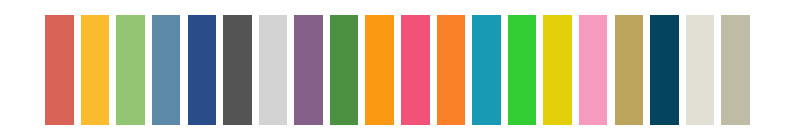

In [2]:
# define colors
purple = '#856088'
pink = '#F25278'
red = '#d96256'
lightgreen = '#93c572'
darkgreen = '#4c9141'
lightblue = '#5d8aa8'
darkblue = '#284d88'
white = '#fafafa'
lightgray = '#d3d3d3'
darkgray ='#545454'
lightorange = '#fabc2e'
darkorange = '#fb9912'
lightyellow = '#e4d00a'
lightgreen2 = '#32CD32'
lightblue2 = '#189AB4'
darkblue2 = '#05445E'
lightpink = '#F79AC0'
darkorange2 = '#FA8128'
darkyellow = '#BDA55D'
lightgray2 = '#E2E0D4'
lightgray3 = '#BFBBA4'

colors = [
    red, lightorange, lightgreen, lightblue, darkblue, 
    darkgray, lightgray, purple, darkgreen, darkorange,
    pink, darkorange2, lightblue2, lightgreen2, lightyellow,
    lightpink, darkyellow, darkblue2, lightgray2, lightgray3
]

plt.figure(figsize=(10, 1.5))
plt.bar(range(len(colors)), height=1, color=colors)
__ = plt.axis('off')

#### load data

In [5]:
# load ella seqscope results
fn = '../ella/output_ella/ella_seqscope.pkl'
res_dict = pd.read_pickle(fn)
types_list = res_dict['types_list']
genes_dict = res_dict['genes_dict']
cells_dict = res_dict['cells_dict']
p_fdr_dict = res_dict['p_fdr_dict']
score_dict = res_dict['score_dict']
lam_dict = res_dict['lam_dict']
label_dict = res_dict['label_dict']
del res_dict

In [6]:
# load seqscope processed un/sp data
path = '../seqscope_unsp_dict.pkl'
pickle_dict = pd.read_pickle(path)
seqscope_type_list = pickle_dict['seqscope_type_list']
seqscope_gene_list_dict = pickle_dict['seqscope_gene_list_dict']
seqscope_cell_list_dict = pickle_dict['seqscope_cell_list_dict']
seqscope_unsp_df = pickle_dict['seqscope_unsp_df']
seqscope_sp_df = pickle_dict['seqscope_sp_df'] 

#### compute ratio

In [7]:
def compute_ratio(type_list, gene_list_dict, cell_list_dict, sp_df, unsp_df, c0=1):
    '''
    Function of computing the avg unsp/sp ratio of all avl cells for each gene in each cell type
    Args:
        c0: add this const to both nominator and denominator (=1 by default)
        type_list: list of cell types
        gene_list_dict
        cell_list_dict
        sp_df
        unsp_df
    Returns:
        dict of cell types, each has the ratio for all genes, invalid values are -1
        dict of cell types, number of cells avl for each gene
    '''
    ratio_dict = {} # ratio
    ncavl_dict = {} # num of cells avl

    for t in type_list:
        print(f'compute unsp/sp ratio for cell type {t}')
        gl_t = gene_list_dict[t]
        cl_t = cell_list_dict[t]
        unsp_df_t = unsp_df[unsp_df.cell.isin(cl_t)].copy()
        sp_df_t = sp_df[sp_df.cell.isin(cl_t)].copy()
        ratio_t = np.full(len(gl_t), -1.0)
        ncavl_t = np.full(len(gl_t), -1.0)
        for ig, g in enumerate(gl_t[:]):
            unsp_df_t_g = unsp_df_t[unsp_df_t.gene==g]
            sp_df_t_g = sp_df_t[sp_df_t.gene==g]
            cl_t_g = np.unique(unsp_df_t_g.cell.unique().tolist()+sp_df_t_g.cell.unique().tolist()).tolist()
            if len(cl_t_g)>0:
                ratio_t_c = np.full(len(cl_t_g), -1.0)
                for ic, c in enumerate(cl_t_g):
                    unsp_df_t_g_c = unsp_df_t_g[unsp_df_t_g.cell==c]
                    sp_df_t_g_c = sp_df_t_g[sp_df_t_g.cell==c]
                    n_unsp = unsp_df_t_g_c.umi.sum()
                    n_sp = sp_df_t_g_c.umi.sum()
                    ratio_t_c[ic] = (n_unsp+c0)/(n_sp+c0) # add c0
                # for each gene, the mean ratio of all cells
                ratio_t[ig] = np.mean(ratio_t_c) 
                ncavl_t[ig] = len(cl_t_g)
            else:
                ratio_t[ig] = -1
        ratio_dict[t] = ratio_t
        ncavl_dict[t] = ncavl_t
    
    return ratio_dict, ncavl_dict

In [8]:
# compute ratio_dict and ncavl_dict
start = timeit.default_timer()
ratio_dict, ncavl_dict =  compute_ratio(seqscope_type_list, 
                                        seqscope_gene_list_dict, 
                                        seqscope_cell_list_dict, 
                                        seqscope_sp_df, 
                                        seqscope_unsp_df, 
                                        c0=1)
stop = timeit.default_timer()
print('Time: ', stop - start) # ~426s

compute unsp/sp ratio for cell type H1
compute unsp/sp ratio for cell type H2
compute unsp/sp ratio for cell type TD1
compute unsp/sp ratio for cell type TD2
Time:  635.074079472106


In [9]:
# check if the two gene lists are identical
for t in types_list:
    gl1 = seqscope_gene_list_dict[t]
    gl2 = genes_dict[t]
    com = list(set(gl1).intersection(gl2))
    print(f'gl1={len(gl1)} gl2={len(gl2)} com={len(com)}')

gl1=1295 gl2=1295 com=1295
gl1=1318 gl2=1318 com=1318
gl1=497 gl2=497 com=497
gl1=1349 gl2=1349 com=1349


In [10]:
# build df
ratio_df_dict = {}
for t in types_list:
    pv_t = p_fdr_dict[t]
    label_t = label_dict[t]
    score_t = score_dict[t]
    gene_t = genes_dict[t]
    ratio_t = ratio_dict[t]
    ratio_df_dict[t] = pd.DataFrame({'gene':gene_t, 'pv':pv_t, 'label':label_t, 'score':score_t, 'ratio':ratio_t})

In [11]:
# save for later use
path = 'output/ratio_df_dict.pkl'
with open(path, 'wb') as f:
    pickle.dump(ratio_df_dict, f)

In [12]:
# load ratio_df_dict
path = 'output/ratio_df_dict.pkl'
ratio_df_dict = pd.read_pickle(path)

#### all types together

In [13]:
# merged df
merged_df = pd.concat(ratio_df_dict.values(), ignore_index=True)
merged_df = merged_df[merged_df.ratio>-1]
merged_df.head(3)

,gene,pv,label,score,ratio
0,Alb,0.000458,2,0.595768,0.007497
1,mt-Co1,0.000525,2,0.595768,0.221634
2,Gm26924,0.000476,2,0.595768,0.022623


In [29]:
# wilcoxon cluster 1 vs 2-5 
sample1 = merged_df['ratio'][(merged_df.label==0)].values
sample2 = merged_df['ratio'][(merged_df.label==1)|(merged_df.label==2)|(merged_df.label==3)|(merged_df.label==4)].values
__statistic, p_value1 = mannwhitneyu(sample1, sample2)
print(f'1 vs 2-5 \np={p_value1}')
print(f'fc={np.mean(sample1)/np.mean(sample2)}')
p12 = [p_value1]

# wilcoxon cluster 1 vs all else
sample3 = merged_df['ratio'][(merged_df.label==-1)|(merged_df.label==1)|(merged_df.label==2)|(merged_df.label==3)|(merged_df.label==4)].values
__statistic, p_value2 = mannwhitneyu(sample1, sample3)
print(f'1 vs others \np={p_value2}')
print(f'fc={np.mean(sample1)/np.mean(sample3)}')
p13 = [p_value2]

1 vs 2-5 
p=7.911069303413832e-21
fc=2.5210343912286004
1 vs others 
p=0.5776468097776155
fc=1.080536060287949


In [26]:
# bar plot
means = [
    (merged_df.ratio)[merged_df.label==0].mean(),
    (merged_df.ratio)[(merged_df.label!=0)&(merged_df.label!=-1)].mean(),
    (merged_df.ratio)[merged_df.label!=-1].mean(),
]

# Individual data points for each category
data_points = [
    (merged_df.ratio)[merged_df.label==0],
    (merged_df.ratio)[(merged_df.label!=0)&(merged_df.label!=-1)],
    (merged_df.ratio)[merged_df.label!=-1],
]

# remove outliers
lbs = []
ubs = []
data_points2 = []
for j in range(len(data_points)):
    data_j = data_points[j]
    
    # IQR
    Q1 = np.percentile(data_j, 25)
    Q3 = np.percentile(data_j, 75)
    # IQR = Q3 - Q1
    lower_bound = Q1
    upper_bound = Q3
    lbs.append(np.maximum(means[j]-lower_bound,0))
    ubs.append(np.maximum(upper_bound-means[j],0))
    
    data_j2 = data_j[(data_j >= lower_bound) & (data_j <= upper_bound)]
    
    data_points2.append(data_j2)

In [27]:
def sig_symb(p_value):
    if p_value <= 0.001:
        sig_symbol = '***'
    elif p_value <= 0.01:
        sig_symbol = '**'
    elif p_value <= 0.05:
        sig_symbol = '*'
    else:
        sig_symbol = ''
    return sig_symbol

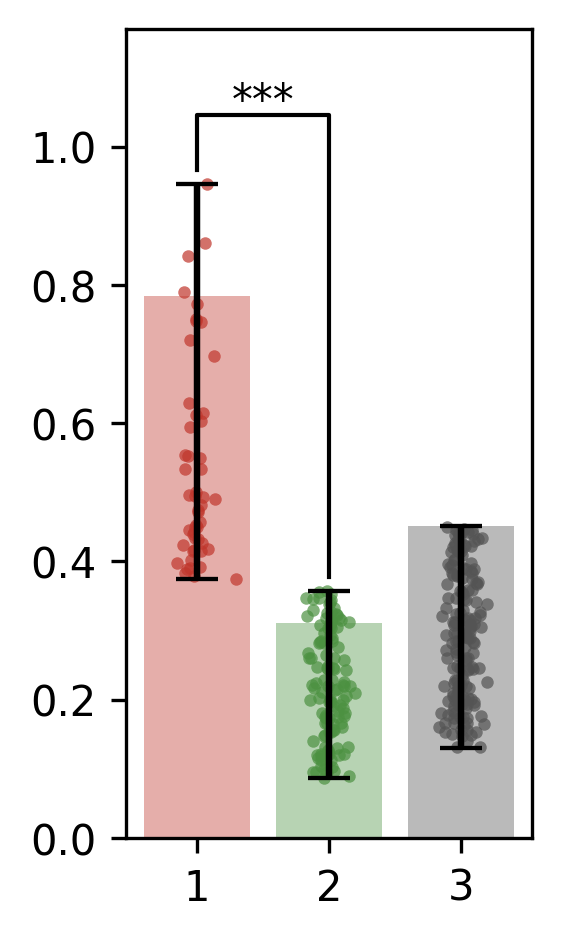

In [41]:
nr = 1
nc = 1
ss_nr = 3.5
ss_nc = 7/4
fig = plt.figure(figsize=(nc*ss_nc, nr*ss_nr), dpi=300)
gs = fig.add_gridspec(nr,nc,
                      width_ratios=[1]*nc,
                      height_ratios=[1]*nr)
gs.update(wspace=0.0, hspace=0.0)
ax = plt.subplot(gs[0, 0])

colors = [red, darkgreen, darkgray]
bar_pos = np.array([1,2,3])

# bar
bars = ax.bar(bar_pos, means, yerr=np.array([lbs, ubs]), 
              capsize=5, 
              color=colors,
              zorder=1,
              alpha=0.4)
# the std 
bars = ax.bar(bar_pos, means, yerr=np.array([lbs, ubs]), 
              capsize=5, 
              zorder=3,
              alpha=0)

# Define the width of the spread
width = bars[0].get_width() / 1.0

# Adding spread dots
for _i, (i, data) in enumerate(zip(bar_pos, data_points2)):
    # Spread dots around the center of the bar
    x = np.random.normal(i, width/10, size=len(data))
    ax.plot(x, data, '.', 
            color=colors[_i], 
            markeredgewidth=0, mec='none', alpha=0.7, zorder=1)

# add 1 vs 2-5 pv
hgap_big = 0.1
hgap_small = 0.02
for j, p in enumerate(p12[:]):
    x1 = bar_pos[::3][j]
    x2 = x1+1
    bar1_max = means[j*3]+ubs[j*3]
    bar2_max = means[j*3+1]+ubs[j*3+1]
    bar12_max = np.maximum(bar1_max, bar2_max)
    
    if p<=0.05:
        ax.plot(
            [x1, x1, x2, x2],
            [bar1_max+hgap_small, bar12_max+hgap_big, bar12_max+hgap_big, bar2_max+hgap_small],
            lw=1, 
            color='black'
        )

        ax.text((x1+x2)/2, bar12_max+hgap_big+hgap_small, sig_symb(p), ha='center', va='center')
    
# add 1 vs others pv
hgap_big = 0.1*2
hgap_small = 0.02
for j, p in enumerate(p13[:]):
    x1 = bar_pos[::3][j]
    x2 = x1+2
    bar1_max = means[j*3]+ubs[j*3]
    bar2_max = means[j*3+2]+ubs[j*3+2]
    bar12_max = np.maximum(bar1_max, bar2_max)
    
    if p<=0.05:
        ax.plot(
            [x1, x1, x2, x2],
            [bar1_max+hgap_small, bar12_max+hgap_big, bar12_max+hgap_big, bar2_max+hgap_small],
            lw=1, 
            color='black'
        )

        ax.text((x1+x2)/2, bar12_max+hgap_big+hgap_small, sig_symb(p), ha='center', va='center')
    
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('')
ax.set_ylim((0, 1.17))

# plt.savefig(f'figs/fig_unsp_all.pdf', dpi=300, bbox_inches='tight')